### Example: Training a neural network for circuit performance prediction

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from functools import partial

import torch 
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

from torchmetrics import MeanAbsolutePercentageError

#### Set computing device

In [2]:
device      = 'cpu'

if torch.cuda.is_available():
    device  = 'cuda'

#### Load a data set

In [4]:
df = pd.read_csv('/home/moldenhauert/Documents/repo/PREDATOR/data/geometrical/V10/sym_amplifier_xt018_filtered_data_V10.csv')

#### Define inputs and outputs

In [5]:
geometricalDesignSpace  = ['Ldp1', 'Lcm1', 'Lcm2', 'Lcm4', 'Wdp1', 'Wcm1', 'Wcm2', 'Wcm4', 'Mcm12', 'Mcm22']

outputSpace             = ['a_0', 'ugbw', 'pm', 'gm', 'cmrr', 'psrr_p', 'voff_stat', 'sr_r', 'sr_f', 'idd', 'area']


ins                     = len(geometricalDesignSpace)
outs                    = len(outputSpace)

#### Define masks for data preparation

In [6]:
inversionMaskI  = torch.tensor([False, False, False, False, False, False, False, False, False, False]).to(device)
logMaskI        = torch.tensor([True, True, True, True, True, True, True, True, False, False]).to(device)

edValues        = torch.tensor(df[geometricalDesignSpace].values, dtype = torch.float32).to(device)

edValues[:, torch.logical_or(inversionMaskI, logMaskI)]   = torch.log10(torch.abs(edValues[:, torch.logical_or(inversionMaskI, logMaskI)]))

inMaxs         = torch.max(edValues, dim = 0).values.to(device)
inMins         = torch.min(edValues, dim = 0).values.to(device)

edValuesScaled  = (edValues - inMins) / (inMaxs - inMins)

In [7]:
inversionMaskO  = torch.tensor([False, False, False, True, False, False, False, False, True, False, False]).to(device)

logMaskO        = torch.tensor([False, True, False, False, False, False, True, True, True, True, True]).to(device)

outValues       = torch.tensor(df[outputSpace].values, dtype = torch.float32).to(device)

outValuesOrigin = outValues.detach().clone()

outValues[:, inversionMaskO] = torch.neg(outValues[:, inversionMaskO])

outValues[:, logMaskO]   = torch.log10(outValues[:, logMaskO])

outMaxs         = torch.max(outValues, dim = 0).values.to(device)
outMins         = torch.min(outValues, dim = 0).values.to(device)

outValuesScaled = (outValues - outMins) / (outMaxs - outMins)

#### Set-up of the training procedure

In [8]:
class Transformer(Dataset):

    def __init__(self, features, targets):

        self.x_train = features
        self.y_train = targets

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]


In [9]:
def load_data(features, targets):

    ds = Transformer(features, targets)

    trainSet, testSet = torch.utils.data.random_split(ds, [round(features.shape[0]*0.7), features.shape[0]-round(features.shape[0]*0.7)], generator=torch.Generator().manual_seed(42))

    return trainSet, testSet

In [10]:
trainSet, testSet = load_data(edValuesScaled, outValuesScaled) 

#### Define neural network architecture

In [11]:
class Net(nn.Module):
    def __init__(self) -> nn.Module:
        super().__init__()

        self.layer1 = nn.Linear(ins, 32)

        self.layer2 = nn.Linear(32, 128)

        self.layer3 = nn.Linear(128, 512)

        self.layer4 = nn.Linear(512, 128)

        self.layer5 = nn.Linear(128, 64)

        self.layer6 = nn.Linear(64, 32)

        self.layer7 = nn.Linear(32, outs)


    def forward(self, x):

        return self.layer7(F.relu(self.layer6(F.relu(self.layer5(F.relu(self.layer4(F.relu(self.layer3(F.relu(self.layer2(F.relu(self.layer1(x)))))))))))))

#### Prepare data sets

In [12]:
testAbs                 = int(len(trainSet)*0.8)
trainSubset, valSubset  = torch.utils.data.random_split(trainSet, [testAbs, len(trainSet) - testAbs])

trainLoader             = DataLoader(trainSubset, batch_size = 8, shuffle = True)

valLoader               = DataLoader(valSubset, batch_size = 8, shuffle = True)

#### Training procedure

In [13]:
# Initialize the neural net
net = Net()

net.to(device)

mape = MeanAbsolutePercentageError().to(device)

mapeMin = float('inf')

valLossList = []
  
# Define the loss function and optimizer
criterion = F.l1_loss

optimizer = torch.optim.Adam(net.parameters(), lr=0.00014)

for k, epoch in enumerate(range(50)):

    for data in trainLoader:
        inputs, targets = data
        targets = targets.reshape((targets.shape[0], outs))
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()


    # validation
    valLoss = 0.0
    mapeSum = 0


    for data in valLoader:
        with torch.no_grad():
            inputs, targets = data
            targets = targets.reshape((targets.shape[0], outs))
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)

            loss = criterion(outputs, targets)
            valLoss += loss.item()

            # Accuracy
            outputsScaled = outputs * (outMaxs - outMins) + outMins 
            outputsScaled[:, logMaskO] = torch.pow(10, outputsScaled[:, logMaskO])
            outputsScaled[:, inversionMaskO] = torch.neg(outputsScaled[:,inversionMaskO])

            targetsScaled = targets * (outMaxs - outMins) + outMins 
            targetsScaled[:, logMaskO] = torch.pow(10, targetsScaled[:, logMaskO])
            targetsScaled[:, inversionMaskO] = torch.neg(targetsScaled[:,inversionMaskO])

            m = mape(outputsScaled, targetsScaled).item()

            mapeSum += m

    
    valLossList.append(valLoss)
    
    mapeMean = mapeSum/len(valSubset)

    if mapeMean < mapeMin:
        bestTrainedModel = net
        mapeMin = mapeMean
        print('New best trained Model in epoch ' + str(k))
        print(mapeMean)

    print('Finished epoch: ' + str(k))


New best trained Model in epoch 0
0.0732802023118046
Finished epoch: 0
New best trained Model in epoch 1
0.052719693041756076
Finished epoch: 1
New best trained Model in epoch 2
0.03934018383149426
Finished epoch: 2
New best trained Model in epoch 3
0.03613295608087013
Finished epoch: 3
New best trained Model in epoch 4
0.03587192390382691
Finished epoch: 4
New best trained Model in epoch 5
0.03259658776297282
Finished epoch: 5
Finished epoch: 6
New best trained Model in epoch 7
0.02702786863630586
Finished epoch: 7
New best trained Model in epoch 8
0.026021188886806525
Finished epoch: 8
New best trained Model in epoch 9
0.024524219360589766
Finished epoch: 9
Finished epoch: 10
New best trained Model in epoch 11
0.02353835262980198
Finished epoch: 11
Finished epoch: 12
New best trained Model in epoch 13
0.023087720460604748
Finished epoch: 13
New best trained Model in epoch 14
0.015539855304172234
Finished epoch: 14
Finished epoch: 15
New best trained Model in epoch 16
0.01513595202269

#### Loss plot

Text(0, 0.5, 'Loss Value')

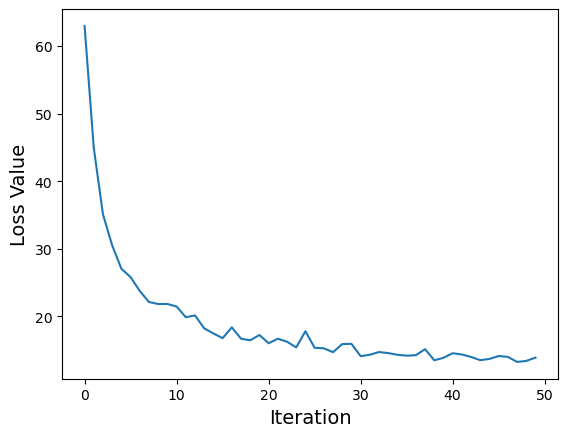

In [14]:
x       =  list(range(len(valLossList)))
y       = valLossList

fig, ax = plt.subplots()

ax.plot(x, y)

ax.set_xlabel('Iteration', fontsize = 14)
ax.set_ylabel('Loss Value', fontsize = 14)

#### Performance on test set

In [15]:
trainedModel = bestTrainedModel

testLoader = torch.utils.data.DataLoader(testSet, batch_size=8, shuffle=False)

mapeSum = 0

with torch.no_grad():
    for j, data in enumerate(testLoader):
        inputs, targets = data
        targets = targets.reshape((targets.shape[0], outs))
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = trainedModel(inputs)

        # Accuracy
        outputsScaled = outputs * (outMaxs - outMins) + outMins 
        outputsScaled[:, logMaskO] = torch.pow(10, outputsScaled[:, logMaskO])
        outputsScaled[:, inversionMaskO] = torch.neg(outputsScaled[:,inversionMaskO])

        targetsScaled = targets * (outMaxs - outMins) + outMins 
        targetsScaled[:, logMaskO] = torch.pow(10, targetsScaled[:, logMaskO])
        targetsScaled[:, inversionMaskO] = torch.neg(targetsScaled[:,inversionMaskO])

        # print(outputsScaled[0])
        # print(targetsScaled[0])

        m = mape(outputsScaled, targetsScaled).item()

        mapeSum += m

meanMape = mapeSum/len(testSet)
    
print("Mean MAPE: " + str(meanMape))

Mean MAPE: 0.010262778800219896
